In [112]:
%pip install scikit-image

     --------------------------------------- 12.0/12.0 MB 13.4 MB/s eta 0:00:00
     ------------------------------------- 195.6/195.6 KB 12.4 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 12.1 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 11.9 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\thoma\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from re import I
import librosa,sys
import matplotlib.pyplot as plt
import numpy as np
from librosa import display
import scipy
import math
import os
from random import *
from skimage import io
from skimage import color
from skimage.util import img_as_ubyte

def fft_plot(audio, sampling_rate):
  n=len(audio)
  T= 1/sampling_rate
  yf= scipy.fft.fft(audio)
  xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
  fig, ax = plt.subplots()
  ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
  plt.grid()
  plt.xlabel("Frequency -->")
  plt.ylabel("Magnitude")
  return plt.show()

def spectrogram(samples, sample_rate, stride_ms = 10.0, window_ms = 20.0, min_freq=2000, max_freq = 15000, eps = 1e-14):
 
  stride_size = int(0.001 * sample_rate * stride_ms)
  window_size = int(0.001 * sample_rate * window_ms)

  # Extract strided windows
  truncate_size = (len(samples) - window_size) % stride_size
  samples = samples[:len(samples) - truncate_size]
  nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
  nstrides = (samples.strides[0], samples.strides[0] * stride_size)
  windows = np.lib.stride_tricks.as_strided(samples, 
                                        shape = nshape, strides = nstrides)
    
  assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

  # Window weighting, squared Fast Fourier Transform (fft), scaling
  weighting = np.hanning(window_size)[:, None]
    
  fft = np.fft.rfft(windows * weighting, axis=0)
  fft = np.absolute(fft)
  fft = fft**2
    
  scale = np.sum(weighting**2) * sample_rate
  fft[1:-1, :] *= (2.0 / scale)
  fft[(0, -1), :] /= scale
    
  # Prepare fft frequency list
  freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
  
  # Compute spectrogram feature
  startind=np.where( freqs >=min_freq)[0][0] 
  endind = np.where( freqs <=max_freq)[0][-1] + 1
  #print(str(startind)+":"+str(endind))
  specgram = np.log(fft[startind:endind, :] + eps)
  return specgram
  
def plot_bird(file_path):
  samples, sampling_rate = librosa.load(file_path, sr= None, mono=True, offset=0.0, duration = None)
  spec=spectrogram(samples,sampling_rate)
  plt.imshow(spec)
  plt.imsave("file_path")
  plt.xlabel(file_path+" Time frame windows")
  plt.ylabel("Frequency")
  plt.show()

def eval_amplitude(samples):
  max=-1
  sum=0.0
  for s in samples:
    amp=abs(s)
    if amp > max:
      max=amp
    sum=sum+amp
  return(max,sum/len(samples),sum)

def splice_sound_file(file_path,splice_length):
  samples, sampling_rate = librosa.load(file_path, sr= None, mono=True, offset=0.0, duration = None)
  print("file length ",len(samples))
  sounds=[]
  remaining=len(samples)
  start=0
  while(remaining > 0):
    #print("remaining: "+str(remaining))
    end=splice_length
    if(remaining < splice_length):
      if(remaining > (splice_length/2)):
        #more than half of time remaining
        #back it up 
        start -=(splice_length-remaining) 
        end=splice_length        
        if start < 0:
          #clip is less than splice_length, add empty to end
          start=0
          end=remaining
          sound=samples[start:end]
          add=np.empty((1,splice_length-end))
          add[:]=0.0
          sound=np.append(sound,add)
          sounds.append(sound)
          return sounds
      else:
        return sounds
    #print(str(start)+":"+str(start+end))
    sounds.append(samples[start:start+end])
    remaining -=splice_length
    start+=splice_length
  return sounds

def spec_to_file(spec, img_file_path):
  #plt.axis('off')
  #plt.axis('tight')
  np.save(img_file_path+".npy",spec)
  img=plt.imshow(spec)
  plt.savefig(img_file_path+".png")
  #now save data in .txt file
  
#Note: This will parse all subdirectories of path.
def process_training_dir_audio(path,specpath,label,labels,sampling_rate,segment_length, minAmp=0.025):
  print(label)
  images=[] #np.empty((0,161,149))
  test_images=[] #np.empty((0,161,149))
  classes=[]
  test_classes=[]
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  for entry in dirs:
    file_path=os.path.join(path, entry)
    if os.path.isfile(file_path):
      if  ".wav" in file_path:
        
        if useLabel:
          labels.append(label);
          useLabel=False;

          print("label "+str(label))
          #rand=1.0 #always put first of each class to test
        classIndex=int(len(labels)-1)
        testFile=False
        #print("processing file: "+file_path)
        if file_path.find("test") >=0:
          testFile=True

        sounds=splice_sound_file(file_path,segment_length)
        countAmps=0
        #print("Num sounds "+str(len(sounds)))
        for sound in sounds:
          (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
          #print("Max amp: "+str(maxAmp)+" avg Amp: "+str(avgAmp))
          if maxAmp >= minAmp:
            #Only use if file reaches minimum amplitude
            countAmps+=1
            dirCount=dirCount+1
            spec=spectrogram(sound,sampling_rate)
            img_file=os.path.join(specpath,label+"_"+str(dirCount))
            if(testFile):
              print("test file "+file_path)
              img_file=img_file+"_test"
              test_images.append(spec)
              test_classes=np.append(test_classes,classIndex)
              #rand=0.1 #reset rand to lower
            else:
              images.append(spec)
              #class is the index of the current label
              classes=np.append(classes, classIndex)
            if(display):
              plt.imshow(spec)
              plt.xlabel(path+" Time frame windows") 
              plt.ylabel("Frequency")
              plt.show()
            spec_to_file(spec,img_file)
            print(img_file)
            # print(spec.dtype)
            # img=(color.convert_colorspace(spec, 'HSV', 'RGB')*255).astype(np.uint8)
            # print(spec.dtype)
            #skimage.io.imsave(img_file, spec)
            #plt.savefig(img_file)
          
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      print("Dir: "+entry)
      (images2,classes2,test_images2,test_classes2)=process_training_dir_audio(os.path.join(path, entry),os.path.join(specpath, entry),entry,labels,sampling_rate,segment_length)
      #print("Num sounds: "+str(len(images2))+" tests sounds: "+str(len(test_images2)))
      if len(images) == 0:
        images=images2
      else:
        print("images: "+str(len(images)))
        print("images2: "+str(len(images2)))
        images = np.append(images,images2,axis=0)
      if len(test_images) == 0:
        test_images = test_images2
      elif len(test_images2) > 0:
        test_images=np.append(test_images,test_images2,axis=0)
      classes=np.append(classes,[classes2])
      test_classes=np.append(test_classes,test_classes2)
 
  if(len(test_images) > 0):
    test_images=np.stack(test_images)
    #print(test_images.shape)
  if(len(images) > 0):
    images=np.stack(images)
    print(images.shape)
  return (images,classes,test_images,test_classes)



def process_dir_audio(path,specpath,label,labels,sampling_rate,segment_length, minAmp=0.025):
  images=[] #np.empty((0,161,149))
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  for entry in dirs:
    file_path=os.path.join(path, entry)
    print("current file: "+file_path)
    if os.path.isfile(file_path):
      if  ".wav" in file_path or ".WAV" in file_path:
        
        if useLabel:
          labels.append(label);
          useLabel=False;

          print("label "+str(label))

        sounds=splice_sound_file(file_path,segment_length)
        countAmps=0
        print("Num sounds "+str(len(sounds)))
        for sound in sounds:
          (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
          #print("Max amp: "+str(maxAmp)+" avg Amp: "+str(avgAmp))
          if maxAmp >= minAmp:
            #Only use if file reaches minimum amplitude
            countAmps+=1
            dirCount=dirCount+1
            spec=spectrogram(sound,sampling_rate)
            img_file=os.path.join(specpath,label+"_"+str(dirCount))
            images.append(spec)
            #class is the index of the current label
            if(display):
              plt.imshow(spec)
              plt.xlabel(path+" Time frame windows") 
              plt.ylabel("Frequency")
              plt.show()
            spec_to_file(spec,img_file)
            # print(spec.dtype)
            # img=(color.convert_colorspace(spec, 'HSV', 'RGB')*255).astype(np.uint8)
            # print(spec.dtype)
            #skimage.io.imsave(img_file, spec)
            #plt.savefig(img_file)
          
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      images2=process_dir_audio(os.path.join(path, entry),os.path.join(specpath, entry),entry,labels,sampling_rate,segment_length)
      #print("Num sounds: "+str(len(images2))+" tests sounds: "+str(len(test_images2)))
      if len(images) == 0:
        images=images2
      else:
       
        images = np.append(images,images2,axis=0)
      
  if(len(images) > 0):
    images=np.stack(images)
    print(images.shape)
  return images

def spec_from_file(spec_file_path):
  spec = np.load(spec_file_path)
  return spec

def process_training_dir_spectrograms(path,label,labels):
  print(label)
  images=[] #np.empty((0,161,149))
  test_images=[] #np.empty((0,161,149))
  classes=[]
  test_classes=[]
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  for entry in dirs:
    file_path=os.path.join(path, entry)
    if os.path.isfile(file_path):
      if  ".npy" in file_path:
        if useLabel:
          labels.append(label);
          useLabel=False;
          print("label "+str(label))
          #rand=1.0 #always put first of each class to test
        classIndex=int(len(labels)-1)
        testFile=False
        print("processing file: "+file_path)
        spec=spec_from_file(file_path)
        #if file_path.find("test") >=0:
        #  testFile=True
        if(testFile):
          #print("test file "+file_path)
          test_images.append(spec)
          test_classes=np.append(test_classes,classIndex)
          #rand=0.1 #reset rand to lower
        else:
          images.append(spec)
          #class is the index of the current label
          #print(file_path+" "+str(classIndex))
          classes=np.append(classes, classIndex)
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      (images2,classes2,test_images2,test_classes2)=process_training_dir_spectrograms(os.path.join(path, entry),entry,labels)
      if len(images) == 0:
        images=images2
      else:

        images = np.append(images,images2,axis=0)
      if len(test_images) == 0:
        test_images = test_images2
      elif len(test_images2) > 0:
        test_images=np.append(test_images,test_images2,axis=0)
      classes=np.append(classes,[classes2])
      test_classes=np.append(test_classes,test_classes2)
 
  if(len(test_images) > 0):
    test_images=np.stack(test_images)
    #print(test_images.shape)
  if(len(images) > 0):
    images=np.stack(images)
    print(images.shape)
  return (images,classes,test_images,test_classes)



BirdSongs
Dir: BirdSongs
BirdSongs
Dir: background_noise
background_noise
label background_noise
file length  1426634
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_1
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_2
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_3
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_4
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_5
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_6
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_7
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_8
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_9
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_10
D:\Grassland\Data\Spectrograms\BirdSongs\background_noise\background_noise_11
D:\Grassland\Data\Spectrograms\Bi

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

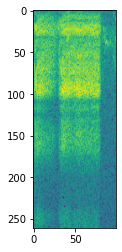

In [4]:
import os
from tensorflow.keras.layers.experimental import preprocessing
make_spectrograms=True
segment_length=44100
sampling_rate=44100
spec_path= os.path.join("D:",os.sep,"Grassland","Data","Spectrograms")
labels=[]
if make_spectrograms:
    file_path= os.path.join("D:",os.sep,"Grassland","Data","Recordings","Training")
    (images,classes,test_images,test_classes)=process_training_dir_audio(file_path,spec_path,"BirdSongs",labels,sampling_rate,segment_length)
else:
    labels=["backgrond_noise","bobof_whine","bobom_song","bobo_chunk","bobo_flight","meadowm","meadow_chatter","robin","wind"]
    (images,classes,test_images,test_classes)=process_training_dir_spectrograms(spec_path,"BirdSongs",labels)
images=np.asarray(images)
print(images.shape)
classes=classes.astype(int)
test_classes=test_classes.astype(int)

# layer = preprocessing.Normalization()
# layer.adapt(images) 
# normalized_images = layer(images)
# print(normalized_images[0])
# print("Normalization layer: ")
# print(layer)
# #use same adaptation as train images for the others
# test_images=layer(test_images)



In [38]:
print(len(classes))
print(len(test_classes))

1923
123


In [39]:
print(images.shape)
print(test_images.shape)
print(str(len(classes))+","+str(len(test_classes)))

(1923, 261, 99)
(123, 261, 99)
1923,123


In [34]:
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt



model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=images[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(labels))
    ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(images, classes, epochs=30)


if len(test_images > 0):
    test_loss, test_acc = model.evaluate(test_images,  test_classes, verbose=3)
    print('\nTest accuracy:', test_acc)


Epoch 1/30
64/64 [==============================] - 3s 34ms/step - loss: 2.7322 - accuracy: 0.5758
Epoch 2/30
64/64 [==============================] - 2s 35ms/step - loss: 1.1521 - accuracy: 0.7722
Epoch 3/30
64/64 [==============================] - 2s 35ms/step - loss: 0.5944 - accuracy: 0.8631
Epoch 4/30
64/64 [==============================] - 2s 35ms/step - loss: 0.4376 - accuracy: 0.8812
Epoch 5/30
64/64 [==============================] - 2s 35ms/step - loss: 0.5751 - accuracy: 0.8675
Epoch 6/30
64/64 [==============================] - 2s 34ms/step - loss: 0.4448 - accuracy: 0.9013
Epoch 7/30
64/64 [==============================] - 2s 34ms/step - loss: 0.3738 - accuracy: 0.9198
Epoch 8/30
64/64 [==============================] - 2s 35ms/step - loss: 0.1928 - accuracy: 0.9545
Epoch 9/30
64/64 [==============================] - 2s 35ms/step - loss: 0.3910 - accuracy: 0.9164
Epoch 10/30
64/64 [==============================] - 2s 34ms/step - loss: 0.3977 - accuracy: 0.9277
Epoch 11/

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# i=0
# for img in images:
#   print(labels[int(classes[i])])
#   i=i+1
#   plt.imshow(img)
#   plt.show()

print("*****test images******")

i=0
for img in test_images:
  print(labels[int(test_classes[i])])
  i=i+1
  plt.imshow(img)
  plt.show()


In [ ]:
print(test_images)

In [35]:
import math
def plot_image(i, predictions_array, labels,true_label, img):
  true_label, img = true_label[i], img[i]
  #plt.subplots_adjust(bottom=0.25, right=0.25, top=0.25)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]+str(i)),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_array)))
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def make_predictions(model, images):                                                  
  #model.summary()  
  probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  predictions = probability_model.predict(images)
  return (probability_model,predictions)

In [61]:
labels=[]

file_path= os.path.join("D:",os.sep,"Grassland","Data","Recordings","Freedom")
spec_path= os.path.join("D:",os.sep,"Grassland","Data","Spectrograms","Freedom")
(images)=process_dir_audio(file_path,spec_path,"",labels,sampling_rate,segment_length)

current file: D:\Grassland\Data\Recordings\Freedom\Sensor1
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220529_160000.WAV
label Sensor1
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220529_170000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220529_210000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220529_220000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220529_230000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220530_090000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220530_100000.WAV
file length  129600000
Num sounds 2939
current file: D:\Grassland\Data\Recordings\Freedom\Sensor1\20220530_110000.WAV
file length  129600000

KeyboardInterrupt: 

4/4 [==============================] - 0s 6ms/step
predicted: meadow_chatter, actual: bobo_chunk5
predicted: bobom_song, actual: meadowm4
predicted: meadow_chatter, actual: meadowm10
predicted: wind, actual: robin0
predicted: meadow_chatter, actual: robin5
predicted: wind, actual: robin6
predicted: wind, actual: robin9
predicted: wind, actual: robin10
predicted: wind, actual: robin14
predicted: background_noise, actual: wind3
predicted: background_noise, actual: wind5
predicted: background_noise, actual: wind7
predicted: background_noise, actual: wind8
predicted: background_noise, actual: wind14
predicted: background_noise, actual: wind15
predicted: background_noise, actual: wind16
[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 2, 22, 8, 8, 12, 14, 17, 25]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 2, 22, 7, 8, 10, 14, 11, 18]


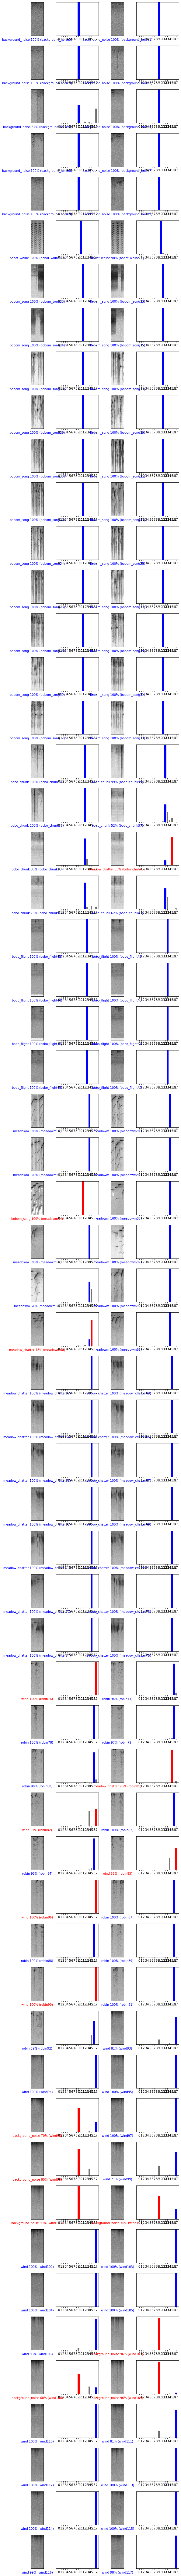

In [31]:

#predictions on test images
  
(probability_model,predictions)=make_predictions(model,test_images)
num_cols = 2
num_rows = math.floor(len(test_images)/num_cols)
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
class_count=[0]*len(labels)
class_correct=[0]*len(labels)
classNum=0 #current index of image within the predicted class
prevClass=-1
for i in range(num_images):
  guess = np.argmax(predictions[i])
  actual=test_classes[i]
  if prevClass != actual:
    classNum=-1
    prevClass=actual
  classNum+=1
  class_count[actual]+=1
  if guess==actual: 
    class_correct[test_classes[i]]+=1
  else:
    print("predicted: "+labels[guess]+", actual: "+labels[test_classes[i]]+str(classNum))
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], labels,test_classes, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)


  plot_value_array(i, predictions[i], test_classes)
  

print(class_count)
print(class_correct)
for i in range(len(labels)):
  if class_count[0] > 0:
    print(labels[i]+": "+str(class_correct[i])+" out of "+str(class_count[i])+" ("+str(class_correct[i]/class_count[i])+")")
plt.tight_layout(pad=2.0,h_pad=1.5)
plt.show()

In [ ]:
model.save("/content/drive/My Drive/WDL/Bird Models/Grassland1")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WDL/Bird Models/Grassland1/assets


In [ ]:
model.save("/content/drive/My Drive/WDL/Bird Models/Grassland1")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WDL/Bird Models/Grassland1/assets


In [ ]:
print(test_images)
model.summary()

[[[-16.40161244 -14.77354154 -14.32914604 ... -14.27479292 -15.81849604
   -16.09983381]
  [-14.77259574 -14.16144377 -13.1728332  ... -13.14362515 -13.32169751
   -13.17497133]
  [-15.99776696 -12.57703194 -12.90609613 ... -14.32448635 -14.00578464
   -15.99086559]
  ...
  [-23.16245269 -23.82536444 -22.38753042 ... -26.35574449 -20.82904378
   -20.30675496]
  [-24.97989363 -22.50079224 -21.91909791 ... -22.53389774 -21.86712455
   -19.49479879]
  [-23.17951526 -21.77291344 -21.67319077 ... -21.26252174 -21.06368596
   -18.80291856]]

 [[-15.48709601 -20.76696415 -15.13535667 ... -15.23950378 -13.64054758
   -14.34501425]
  [-12.67870899 -12.19719247 -14.1924845  ... -13.42351531 -12.90343268
   -14.6948193 ]
  [-12.87381094 -12.46830073 -16.12697287 ... -17.06983995 -14.52018825
   -16.06345119]
  ...
  [-19.81476122 -20.60093439 -19.06618292 ... -22.80971485 -23.00301028
   -24.66513095]
  [-20.95461875 -21.55067493 -18.37975909 ... -22.02081112 -22.73625332
   -22.32003546]
  [-21.

In [ ]:
import tensorflow as tf
# Helper libraries
import numpy as np
from librosa import display
import scipy
import math
import os

def process_locations(model,classLabels,path,sampling_rate,segment_length,minAmp,buckets={}):
  dirs = os.listdir(path)
  currLoc=0
  #two layers of dirs
  for entry in dirs:
    currLoc=currLoc+1
    loc_path=os.path.join(path, entry)
    if os.path.isdir(loc_path):
      if not entry in buckets:
        #no bucket set for this location yet
        buckets[entry]=[0 for i in range(len(classLabels))] 
      loc_bucket=buckets[entry]
      print("processing "+loc_path)
      files=os.listdir(loc_path)
      for file in files:
        process_location_file(model,os.path.join(loc_path,file),buckets[entry],sampling_rate,segment_length,minAmp)
  for b in buckets:
    bucket=buckets[b]
    for i in range(len(bucket)):
      print("class "+str(i)+" total: "+str(round(bucket[i],2)))
    

def process_location_file(model,path,buckets,sampling_rate=44100,segment_length=44100,minAmp=0.025):
  #process a file from a location and add the amplitude to the bucket for each identified class
  display=False
  images=[] #np.empty((0,161,149))
  classes=[]
  amps=[]
  
  if  ".wav" in path:
    print("processing "+path +" at "+str(sampling_rate))
    sounds=splice_sound_file(path,segment_length)
    for sound in sounds:
      (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
      if display:
        print("Max amp: "+str(maxAmp)+" avg Amp: "+str(avgAmp))
      if maxAmp >= minAmp:
        #Only use if file reaches minimum amplitude
        spec=spectrogram(sound,sampling_rate)
        images.append(spec)
        amps.append(sumAmp)
        if(display):
          plt.imshow(spec)
          plt.xlabel(path+" Time frame windows")
          plt.ylabel("Frequency")
          plt.show()
        #now find class of image
    images=np.stack(images)
    print("about to make predictions on "+str(len(images))+" images.")
    (probability_model,predictions)=make_predictions(model,images)
    numImages=len(images)
    
    for i in range(numImages):
      print(str(i)+" of "+str(numImages))
      if display:
        plt.imshow(images[i])
        plt.show()
      predict=predictions[i]
      amp=amps[i]
      print("most likely class: "+str(np.argmax(predict)))
      for c in range(len(predict)):
        #add the probabilistic amplitude to bucket (amp * probability of class c)
        buckets[c]+=amp*predict[c]
        if display:
          print("predicted class: "+str(c))
          print("class: "+str(c)+" likelihood: "+str(round(predict[c],3))+" total value: "+str(round(amp*predict[c])))

  #process location sound files with a saved model

import csv

def load_bucket_file(file_path, num_classes):
  buckets={}
  #encode as follows to remove first BOM character 
  with open(file_path,encoding='utf-8-sig') as csvDataFile:
      csvReader = csv.reader(csvDataFile)
      for row in csvReader:
        location=row[0]
        print(location)
        classNum=int(row[1])
        value=float(row[2])
        if not location in buckets:
          b = [0 for i in range(num_classes)] 
          buckets[location]=b
        bucket=buckets[location]
        bucket[classNum]=value
  return buckets
          
def save_bucket_file(file_path,buckets):
  with open(file_path, 'w', newline='',encoding='utf-8-sig') as csvfile:
    csvWriter=csv.writer(csvfile,delimiter=',')
    
    for loc in buckets.keys():
      bucket=buckets[loc]
      i=0
      for v in bucket: #each class
        row=[loc,str(i),str(v)]
        i=i+1 #increment class num
        csvWriter.writerow(row)


labels=["bobof_whine","kestrel","meadowm","bobom_song","meadow_chatter","bobo_chunk","bobo_flight","background_noise"]
buckets=load_bucket_file("/content/drive/My Drive/WDL/BirdSounds/Locations/bird_buckets.csv",len(labels))
print(buckets)
lmodel=tf.keras.models.load_model("/content/drive/My Drive/WDL/Bird Models/Grassland1")
process_locations(lmodel,labels,"/content/drive/My Drive/WDL/BirdSounds/Locations/",44100,44100,.025,buckets)

save_bucket_file("/content/drive/My Drive/WDL/BirdSounds/Locations/bird_buckets.csv",buckets)

HighSt1
HighSt1
HighSt1
HighSt1
HighSt1
HighSt1
HighSt1
HighSt1
Test
Test
Test
Test
Test
Test
Test
Test
GBH_Middle
GBH_Middle
GBH_Middle
GBH_Middle
GBH_Middle
GBH_Middle
GBH_Middle
GBH_Middle
GBH_West
GBH_West
GBH_West
GBH_West
GBH_West
GBH_West
GBH_West
GBH_West
{'HighSt1': [5.2147955246913905e-06, 17026.875773420557, 93891.9307092011, 4.732773207763999e-06, 7.236218497204144e-05, 184.8931987903828, 5.688343638649999e-09, 13991.569489565441], 'Test': [0.006500371942047881, 40217.83955571411, 0.04023912419618268, 1.0552105355391759e-05, 0.007098273370929359, 8.0579703886834e-06, 4.955515941725902e-05, 0.00015246095648500685], 'GBH_Middle': [572.3968411799087, 1.0309574370618821, 43108320.8070935, 1.9536182242968751, 17908.126932641062, 3792653.0082006524, 7.347592269267127e-05, 60053883.07401814], 'GBH_West': [0.732518932479466, 0.008371609550515182, 37566334.07454927, 0.04302500846420399, 1150.9339940975844, 240329.10148872054, 5.058361962043601e-07, 8034937.756348164]}


KeyboardInterrupt: ignored